In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


In [2]:
train = pd.read_csv("/Users/martinyeh/Desktop/DeepLearning_WU/myproject/RNN/dataset/train.csv",header=None)
X_train = train[0]
Y_train = train[1]
print(X_train.shape)
print(Y_train.shape)
test = pd.read_csv("/Users/martinyeh/Desktop/DeepLearning_WU/myproject/RNN/dataset/test.csv",header=None)
X_test = test[0]
Y_test = test[1]
print(X_test.shape)
print(Y_test.shape)

(183,)
(183,)
(56,)
(56,)


In [3]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/martinyeh/Desktop/DeepLearning_WU/myproject/RNN/dataset/glove.6B.50d.txt')

In [4]:
maxLen = len(max(X_train, key=len).split())

In [5]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`. 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().strip().replace('  ',' ').split(' ')
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j+1

    
    return X_indices

In [6]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(input_dim = vocab_len, output_dim = emb_dim)

    # Step 4 
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [7]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape= input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)  
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 128, return_sequences= True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units = 128)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(units = 5)(X)
    # Add a softmax activation
    X = Activation("softmax")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)

    return model

In [8]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645 

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
X_train_numb = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_onehot = to_categorical(Y_train, num_classes = 5)
X_test_numb = sentences_to_indices(X_test, word_to_index, maxLen)
Y_test_onehot = to_categorical(Y_test, num_classes = 5)

In [12]:
model.fit(X_train_numb, Y_train_onehot, validation_data=(X_test_numb, Y_test_onehot), epochs = 50, batch_size = 32, shuffle=True)


Train on 183 samples, validate on 56 samples
Epoch 1/50
183/183 [==============================] - 3s 15ms/step - loss: 1.5644 - accuracy: 0.2568 - val_loss: 1.4927 - val_accuracy: 0.3214
Epoch 2/50
183/183 [==============================] - 2s 9ms/step - loss: 1.4901 - accuracy: 0.3333 - val_loss: 1.4155 - val_accuracy: 0.4286
Epoch 3/50
183/183 [==============================] - 2s 9ms/step - loss: 1.3844 - accuracy: 0.4044 - val_loss: 1.3415 - val_accuracy: 0.3571
Epoch 4/50
183/183 [==============================] - 2s 9ms/step - loss: 1.2572 - accuracy: 0.5246 - val_loss: 1.1682 - val_accuracy: 0.5357
Epoch 5/50
183/183 [==============================] - 2s 9ms/step - loss: 1.0706 - accuracy: 0.5847 - val_loss: 0.9724 - val_accuracy: 0.6607
Epoch 6/50
183/183 [==============================] - 2s 9ms/step - loss: 0.8526 - accuracy: 0.6776 - val_loss: 0.8422 - val_accuracy: 0.6786
Epoch 7/50
183/183 [==============================] - 2s 9ms/step - loss: 0.6696 - accuracy: 0.7268 -

In [13]:
metrics = pd.DataFrame(model.history.history)
metrics

,val_loss,val_accuracy,loss,accuracy
0,1.492661,0.321429,1.564364,0.256831
1,1.415505,0.428571,1.490137,0.333333
2,1.341512,0.357143,1.384444,0.404372
3,1.168155,0.535714,1.257175,0.524590
4,0.972398,0.660714,1.070588,0.584699
5,0.842211,0.678571,0.852642,0.677596
6,0.684701,0.732143,0.669609,0.726776
7,0.719337,0.732143,0.592612,0.748634
8,0.591512,0.803571,0.584909,0.770492
9,0.423716,0.785714,0.451530,0.786885


<AxesSubplot:>

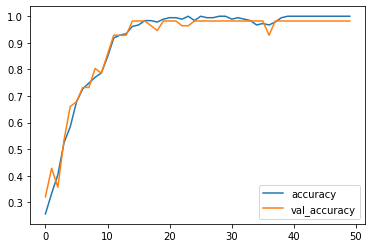

In [14]:
metrics[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

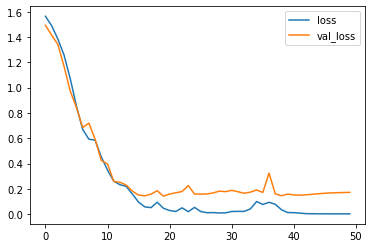

In [15]:
metrics[['loss','val_loss']].plot()

In [16]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
X_test_indices = sentences_to_indices(X_my_sentences, word_to_index, maxLen)

for i in range(len(X_my_sentences)):
    print(X_my_sentences[i] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices)[i])))

i adore you 😄
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😞


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
pred = model.predict(X_test_numb)
result = []
for i in range(len(pred)):
    tmp = list(pred[i])
    y_answer = tmp.index(max(tmp))
    result.append(y_answer)
print(classification_report(Y_test.values, result))
confusion_matrix(Y_test.values, result)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00        18
           3       0.94      1.00      0.97        15
           4       1.00      1.00      1.00         6

    accuracy                           0.98        56
   macro avg       0.99      0.98      0.98        56
weighted avg       0.98      0.98      0.98        56



array([[11,  0,  0,  1,  0],
       [ 0,  5,  0,  0,  0],
       [ 0,  0, 18,  0,  0],
       [ 0,  0,  0, 15,  0],
       [ 0,  0,  0,  0,  6]])